In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/ECE661/ACGAN/"

/content/drive/MyDrive/ECE661/ACGAN


In [ ]:
from __future__ import print_function
import argparse
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [ ]:
def genblock(in_channels, out_channels, kernel_size, stride, padding, norm=False):
    if not norm:
        block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
    else:
        block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.Tanh(),
            )
    return block
    
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()

        # first linear layer
        self.fc1 = nn.Linear(110, 384)
        self.tconv2 = genblock(384, 192, 4, 1, 0)
        self.tconv3 = genblock(192, 96, 4, 2, 1)
        self.tconv4 = genblock(96, 48, 4, 2, 1)
        self.tconv5 = genblock(48, 3, 4, 2, 1, norm=True)

    def forward(self, input):
        input = input.view(-1, 110)
        fc1 = self.fc1(input)
        fc1 = fc1.view(-1, 384, 1, 1)
        tconv2 = self.tconv2(fc1)
        tconv3 = self.tconv3(tconv2)
        tconv4 = self.tconv4(tconv3)
        tconv5 = self.tconv5(tconv4)
        output = tconv5
        return output

In [ ]:
def dblock(in_channels, out_channels, kernel_size, stride, padding, norm=True):
    if norm:
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
        )
    else:
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5, inplace=False),
        )
    return block
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()

        self.conv1 = dblock(3, 16, 3, 2, 1,norm=False)
        self.conv2 = dblock(16, 32, 3, 1, 1)
        self.conv3 = dblock(32, 64, 3, 2, 1)
        self.conv4 = dblock(64, 128, 3, 1, 1)
        self.conv5 = dblock(128, 256, 3, 2, 1)
        self.conv6 = dblock(256, 512, 3, 1, 1)
        self.fc_dis = nn.Linear(4*4*512, 1)
        self.fc_aux = nn.Linear(4*4*512, num_classes)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        conv1 = self.conv1(input)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        conv6 = self.conv6(conv5)
        flat6 = conv6.view(-1, 4*4*512)
        fc_dis = self.fc_dis(flat6)
        fc_aux = self.fc_aux(flat6)
        classes = self.softmax(fc_aux)
        realfake = self.sigmoid(fc_dis).view(-1, 1).squeeze(1)
        return realfake, classes

In [ ]:
dataset ='cifar10'
dataroot = './data/'
workers = 2
batchSize = 100
imageSize = 32
nz = 110
niter = 2
lr = 0.0002
beta1 = 0.5
cuda = True
generatorw = './finalweights/generator_epoch_99.pth'
discriminatorw = './finalweights/discriminator_epoch_99.pth'
outf = './output/'
seed = random.randint(1, 10000)
num_classes = 10
gpu_id = 0

In [ ]:
TEST = True
if not TEST:
    generatorw = ''
    discriminatorw = ''
    niter = 100

In [ ]:
# specify the gpu id if using only 1 gpu
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)

try:
    os.makedirs(outf)
except OSError:
    pass

print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed_all(seed)

Random Seed:  9605


In [ ]:
transform  = transforms.Compose([transforms.ToTensor()])
dataset = dset.CIFAR10(root=dataroot, download=True,transform= transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,shuffle=True, num_workers=workers)

Files already downloaded and verified


In [ ]:
# Define the generator and initialize the weights
generator = Generator(nz)
for layer in generator.modules():
      if isinstance(layer,nn.Conv2d):
        nn.init.normal_(layer.weight.data,0,0.02)
      elif isinstance(layer,nn.BatchNorm2d):
        nn.init.normal_(layer.weight.data,1,0.02)
if generatorw != '':
    generator.load_state_dict(torch.load(generatorw))
print(generator)

Generator(
  (fc1): Linear(in_features=110, out_features=384, bias=True)
  (tconv2): Sequential(
    (0): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv5): Sequential(
    (0): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)


In [ ]:
# Define the discriminator and initialize the weights
discriminator = Discriminator().cuda()
for layer in discriminator.modules():
      if isinstance(layer,nn.Conv2d):
        nn.init.normal_(layer.weight.data,0,0.02)
      elif isinstance(layer,nn.BatchNorm2d):
        nn.init.normal_(layer.weight.data,1,0.02)

if discriminatorw != '':
    discriminator.load_state_dict(torch.load(discriminatorw))
print(discriminator)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# loss functions
dis_loss = nn.BCELoss()
aux_loss = nn.NLLLoss()

In [ ]:
# tensor placeholders
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
eval_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
dis_label = torch.FloatTensor(batchSize)
aux_label = torch.LongTensor(batchSize)
real_label = 1
fake_label = 0

# if using cuda
if cuda:
    discriminator.cuda()
    generator.cuda()
    dis_loss.cuda()
    aux_loss.cuda()
    input, dis_label, aux_label = input.cuda(), dis_label.cuda(), aux_label.cuda()
    noise, eval_noise = noise.cuda(), eval_noise.cuda()

In [ ]:
# define variables
input = Variable(input)
noise = Variable(noise)
eval_noise = Variable(eval_noise)
dis_label = Variable(dis_label)
aux_label = Variable(aux_label)
# noise for evaluation
eval_noise_ = np.random.normal(0, 1, (batchSize, nz))
eval_label = np.random.randint(0, num_classes, batchSize)
eval_onehot = np.zeros((batchSize, num_classes))
eval_onehot[np.arange(batchSize), eval_label] = 1
eval_noise_[np.arange(batchSize), :num_classes] = eval_onehot[np.arange(batchSize)]
eval_noise_ = (torch.from_numpy(eval_noise_))
eval_noise.data.copy_(eval_noise_.view(batchSize, nz, 1, 1))

# setup optimizer
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
avg_loss_D = 0.0
avg_loss_G = 0.0
avg_acc_D = 0.0

avg_loss_D_list = list() 
avg_loss_G_list = list() 
avg_acc_D_list = list()

for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):

      
        discriminator.zero_grad()
        real_cpu, label = data
        batch_size = real_cpu.size(0)
        if cuda:
            real_cpu = real_cpu.cuda()
        input.data.resize_as_(real_cpu).copy_(real_cpu)
        dis_label.data.resize_(batch_size).fill_(real_label)
        aux_label.data.resize_(batch_size).copy_(label)
        dis_output, aux_output = discriminator(input)

        dis_lossD_real = dis_loss(dis_output, dis_label)
        aux_lossD_real = aux_loss(aux_output, aux_label)
        lossD_real = dis_lossD_real + aux_lossD_real
        lossD_real.backward()
        D_x = dis_output.data.mean()

        noise.data.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        label = np.random.randint(0, num_classes, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        class_onehot = np.zeros((batch_size, num_classes))
        class_onehot[np.arange(batch_size), label] = 1
        noise_[np.arange(batch_size), :num_classes] = class_onehot[np.arange(batch_size)]
        noise_ = (torch.from_numpy(noise_))
        noise.data.copy_(noise_.view(batch_size, nz, 1, 1))
        aux_label.data.resize_(batch_size).copy_(torch.from_numpy(label))

        fake = generator(noise)
        dis_label.data.fill_(fake_label)
        dis_output, aux_output = discriminator(fake.detach())
        dis_lossD_fake = dis_loss(dis_output, dis_label)
        aux_lossD_fake = aux_loss(aux_output, aux_label)
        lossD_fake = dis_lossD_fake + aux_lossD_fake
        lossD_fake.backward()
        D_G_z1 = dis_output.data.mean()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        generator.zero_grad()
        dis_label.data.fill_(real_label) 
        dis_output, aux_output = discriminator(fake)
        dis_lossG = dis_loss(dis_output, dis_label)
        aux_lossG = aux_loss(aux_output, aux_label)
        lossG = dis_lossG + aux_lossG
        lossG.backward()
        D_G_z2 = dis_output.data.mean()
        optimizerG.step()

        # compute the average batch loss
        avg_loss_D_batch_list.append(lossG.data.item())
        avg_loss_G_batch_list.append(lossD.data.item()) 

    avg_loss_D_list.append(np.mean(avg_loss_D_batch_list)) 
    avg_loss_G_list.append(np.mean(avg_loss_G_batch_list)) 

    vutils.save_image(
        real_cpu, '%s/real_samples.png' % outf)
    # print('Label for eval = {}'.format(eval_label))
    print(eval_noise.shape)
    fake = generator(eval_noise)
    vutils.save_image(
        fake.data,
        '%s/fake_samples_epoch_%03d.png' % (outf, epoch)
    )
    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
      % (epoch, niter, i, len(dataloader),
          avg_loss_D_list[-1], avg_loss_G_list[-1]))
        

    # do checkpointing
    torch.save(generator.state_dict(), '%s/generator_epoch_%d.pth' % (outf, epoch))
    torch.save(discriminator.state_dict(), '%s/discriminator_epoch_%d.pth' % (outf, epoch))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([100, 110, 1, 1])
[0/2][499/500] Loss_D: 0.3720 Loss_G: 0.1003
torch.Size([100, 110, 1, 1])
[1/2][499/500] Loss_D: -0.0206 Loss_G: 0.2381


In [ ]:
import matplotlib.pyplot as plt 

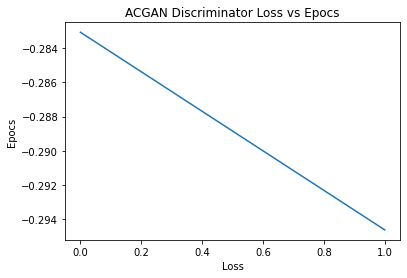

In [ ]:
plt.plot(list(range(epoch+1)),avg_loss_D_list)
plt.xlabel('Loss')
plt.ylabel('Epocs')
plt.title('ACGAN Discriminator Loss vs Epocs')
plt.show()

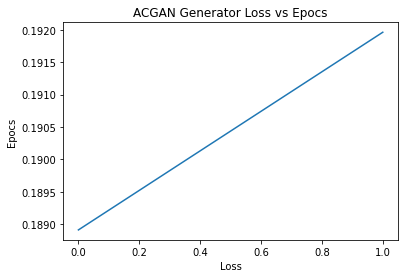

In [ ]:
plt.plot(list(range(epoch+1)),avg_loss_G_list)
plt.xlabel('Loss')
plt.ylabel('Epocs')
plt.title('ACGAN Generator Loss vs Epocs')
plt.show()

In [ ]:
model = Generator(num_classes).cuda()
model.load_state_dict(torch.load('./output/generator_epoch_1.pth'))
model.eval()

Generator(
  (fc1): Linear(in_features=110, out_features=384, bias=True)
  (tconv2): Sequential(
    (0): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv4): Sequential(
    (0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (tconv5): Sequential(
    (0): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

In [ ]:
batchSize = 2
nvector = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1).cuda()
nvector = Variable(nvector)
eval_noise_ = np.random.normal(0, 1, (batchSize, nz))
eval_label = np.random.randint(0, num_classes, batchSize)
eval_onehot = np.zeros((batchSize, num_classes))
eval_onehot[np.arange(batchSize), eval_label] = 1
eval_noise_[np.arange(batchSize), :num_classes] = eval_onehot[np.arange(batchSize)]
eval_noise_ = (torch.from_numpy(eval_noise_))
nvector.data.copy_(eval_noise_.view(batchSize, nz, 1, 1))
print(nvector.shape)
fake = generator(nvector)

torch.Size([2, 110, 1, 1])


In [ ]:
eval_label

array([7, 9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


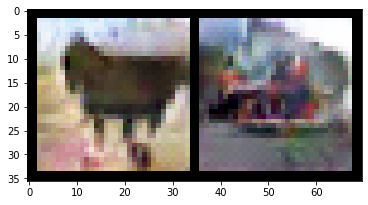

In [ ]:
grid_img = vutils.make_grid(fake, nrow=2).cpu()
plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:
batchSize = 1
nvectorc = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1).cuda()
nvectorc = Variable(nvectorc,requires_grad=False)
nvectorc[0]=nvector[0]+nvector[1]
print(nvectorc.shape)
fake = generator(nvectorc)

torch.Size([1, 110, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


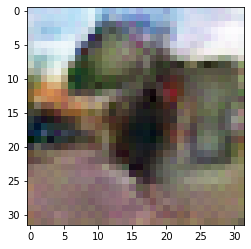

In [ ]:
grid_img = vutils.make_grid(fake, nrow=2).detach().cpu()
plt.imshow(grid_img.permute(1, 2, 0))